In [1]:
!pip install mlflow --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00


# MLflow Training Pipeline on Kaggle for Animal Classification using Custom CNN (Keras) with Optuna


In [2]:
# MLflow Training Pipeline on Kaggle for Animal Classification using Custom CNN (Keras) with Optuna

import os
import hashlib
import mlflow
import mlflow.keras
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import cv2
from imutils import paths
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.callbacks import EarlyStopping

# ========== CONFIGURATION ==========

In [3]:
# ========== CONFIGURATION ==========
EXPERIMENT_NAME = "Animal_CNN_Optuna_Keras"
DATA_DIR = "/kaggle/input/animal/Animal_Dataset"
IMG_SIZE = 224
NUM_EPOCHS = 10
TRIALS = 20



# ========== SETUP MLflow ==========

In [4]:
# ========== SETUP MLflow ==========
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
mlflow.set_experiment(EXPERIMENT_NAME)



2025/04/09 18:46:17 INFO mlflow.tracking.fluent: Experiment with name 'Animal_CNN_Optuna_Keras' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/689641708937928903', creation_time=1744224377923, experiment_id='689641708937928903', last_update_time=1744224377923, lifecycle_stage='active', name='Animal_CNN_Optuna_Keras', tags={}>

# ========== HELPER FUNCTION ==========

In [5]:
# ========== HELPER FUNCTION ==========
def hash_dataset(path):
    hash_md5 = hashlib.md5()
    for root, dirs, files in os.walk(path):
        for f in sorted(files):
            with open(os.path.join(root, f), "rb") as file:
                for chunk in iter(lambda: file.read(4096), b""):
                    hash_md5.update(chunk)
    return hash_md5.hexdigest()




# ========== LOAD AND PREPROCESS IMAGES ==========

In [6]:
# ========== LOAD AND PREPROCESS IMAGES ==========
def load_data(data_dir, img_size=224, test_size=0.2, random_state=42):
    image_paths = list(paths.list_images(data_dir))
    data, labels = [], []

    for img_path in tqdm(image_paths, desc="🔍 Loading images"):
        label = img_path.split(os.path.sep)[-2]
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (img_size, img_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        data.append(img)
        labels.append(label)

    data = np.array(data) / 255.0
    labels = np.array(labels)
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=test_size, stratify=labels, random_state=random_state
    )
    return X_train, X_test, y_train, y_test, le

In [7]:
X_train, X_test, y_train, y_test, le = load_data(DATA_DIR, IMG_SIZE)
num_classes = len(np.unique(y_train))

🔍 Loading images: 100%|██████████| 4374/4374 [00:34<00:00, 126.26it/s]


# ========== BUILD MODEL ==========

In [8]:
def build_model(input_shape=(224, 224, 3), num_classes=10, learning_rate=1e-3, dropout=0.5):
    model = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


# ========== OBJECTIVE FUNCTION FOR TRAINING, TUNNING HYPERPARAMETER, METRIC ==========

In [9]:
# ========== OBJECTIVE FUNCTION ==========
all_histories = {}


def save_plot_and_log(fig, filename, artifact_path):
    fig.savefig(filename)
    mlflow.log_artifact(filename, artifact_path=artifact_path)
    plt.show()
    plt.close(fig)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def objective(trial):
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 1e-3, 1e-4])
    dropout = 0.5
    batch_size = trial.suggest_categorical("batch_size", [32, 64])
    epochs = trial.suggest_categorical("epochs", [10, 15])

    model = build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                        num_classes=num_classes,
                        learning_rate=learning_rate,
                        dropout=dropout)

    with mlflow.start_run():
        # Log parameters
        mlflow.log_params({
            "learning_rate": learning_rate,
            "dropout": dropout,
            "batch_size": batch_size,
            "epochs": epochs,
            "dataset_hash": hash_dataset(DATA_DIR)
        })

        # Huấn luyện
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
            verbose=1
        )

        # Dự đoán và đánh giá
        y_pred = np.argmax(model.predict(X_test), axis=1)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")

        # Log metrics
        mlflow.log_metrics({
            "val_accuracy": acc,
            "val_precision": precision,
            "val_recall": recall,
            "val_f1": f1
        })

        # Log model
        mlflow.keras.log_model(model, "model")

        # Log plot loss/accuracy
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(history.history['loss'], label='Train')
        ax[0].plot(history.history['val_loss'], label='Val')
        ax[0].set_title(f'Trial {trial.number} Loss')
        ax[0].legend()
        ax[1].plot(history.history['accuracy'], label='Train')
        ax[1].plot(history.history['val_accuracy'], label='Val')
        ax[1].set_title(f'Trial {trial.number} Accuracy')
        ax[1].legend()
        plot_filename = f"plot_trial_{trial.number}.png"
        fig.savefig(plot_filename)
        mlflow.log_artifact(plot_filename, artifact_path="plots")
        plt.tight_layout()
        plt.show()  # ✅ In ra sau mỗi trial
        plt.close(fig)

    return f1


# ========== TRAINING AND LOG ==========

[I 2025-04-09 18:47:06,395] A new study created in memory with name: no-name-90386951-6e79-41e7-a310-675387829448
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.2869 - loss: 7.5062 - val_accuracy: 0.3086 - val_loss: 1.3754
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3197 - loss: 1.3725 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3186 - loss: 1.3724 - val_accuracy: 0.3086 - val_loss: 1.3755
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2901 - loss: 1.3768 - val_accuracy: 0.3086 - val_loss: 1.3749
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3103 - loss: 1.3780 - val_accuracy: 0.3086 - val_loss: 1.3751
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:47:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:48:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


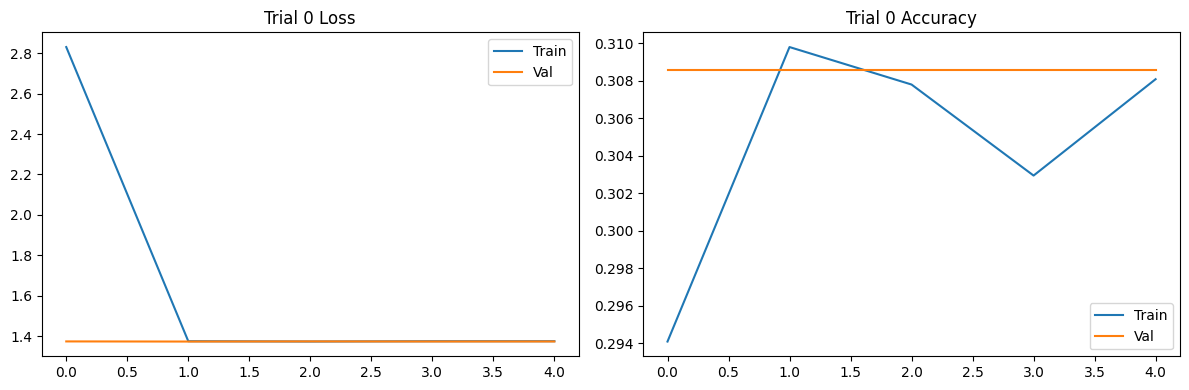

[I 2025-04-09 18:48:05,218] Trial 0 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10}. Best is trial 0 with value: 0.14552713661883968.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.4158 - loss: 1.2549 - val_accuracy: 0.6914 - val_loss: 0.7584
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6670 - loss: 0.8149 - val_accuracy: 0.7394 - val_loss: 0.6415
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7114 - loss: 0.7044 - val_accuracy: 0.7657 - val_loss: 0.5721
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7783 - loss: 0.5500 - val_accuracy: 0.7600 - val_loss: 0.5954
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8241 - loss: 0.4487 - val_accuracy: 0.7714 - val_loss: 0.5706
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8391 - loss: 0.4097 - val_accuracy: 0.7783 - val_loss: 0.5812
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8853 - loss: 0.3085 - val_accuracy: 0.7497 - val_loss: 0.7220
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9037 - loss: 0.2714 - val_acc

2025/04/09 18:48:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:48:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


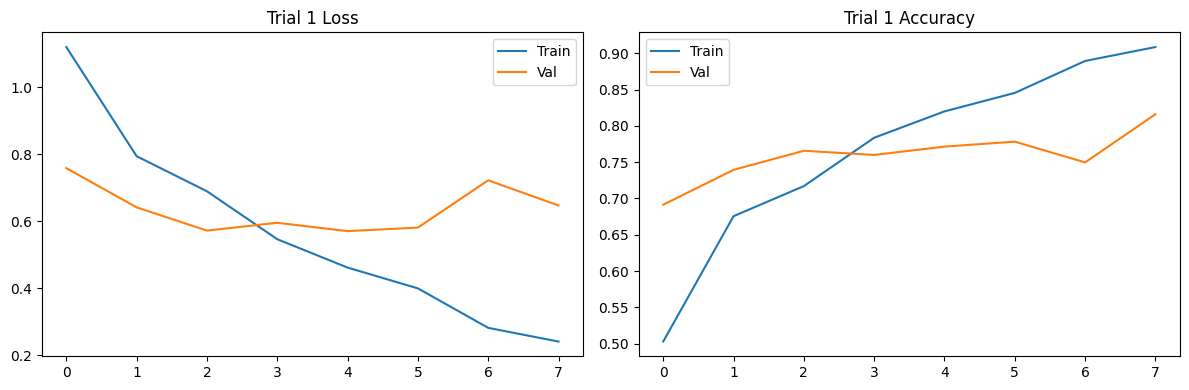

[I 2025-04-09 18:48:58,307] Trial 1 finished with value: 0.767939690737195 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}. Best is trial 1 with value: 0.767939690737195.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.3078 - loss: 7.1660 - val_accuracy: 0.3086 - val_loss: 1.3762
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3069 - loss: 1.3733 - val_accuracy: 0.3086 - val_loss: 1.3751
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3281 - loss: 1.3708 - val_accuracy: 0.3086 - val_loss: 1.3756
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3128 - loss: 1.3752 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3017 - loss: 1.3779 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3178 - loss: 1.3694 - val_accuracy: 0.3086 - val_loss: 1.3751
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3033 - loss: 1.3757 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3028 - loss: 1.3763 - val_acc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:49:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:49:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


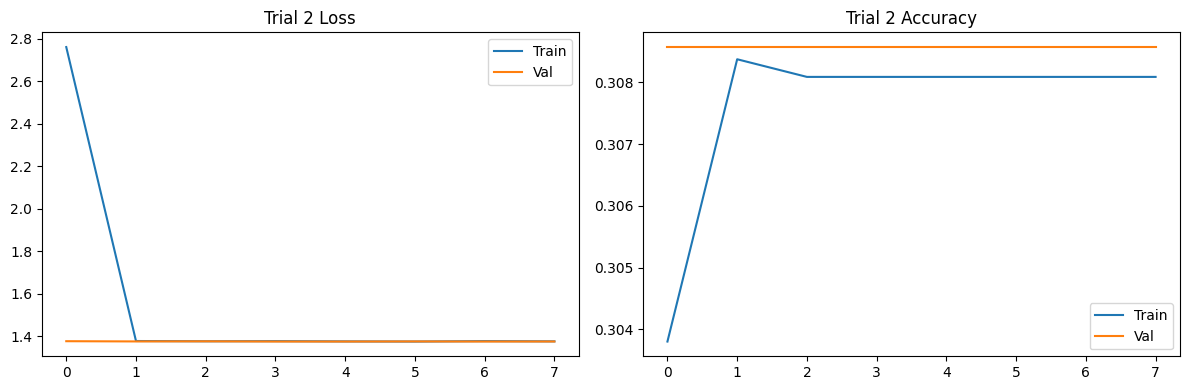

[I 2025-04-09 18:49:50,465] Trial 2 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 10}. Best is trial 1 with value: 0.767939690737195.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.3010 - loss: 11.6910 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.2998 - loss: 1.3774 - val_accuracy: 0.3086 - val_loss: 1.3770
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3079 - loss: 1.3779 - val_accuracy: 0.3086 - val_loss: 1.3756
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3160 - loss: 1.3708 - val_accuracy: 0.3086 - val_loss: 1.3758
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:50:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:50:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


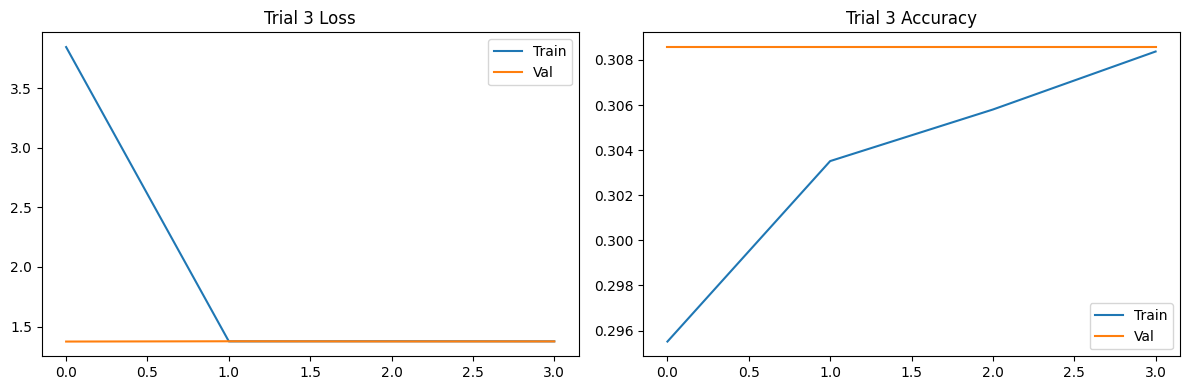

[I 2025-04-09 18:50:31,176] Trial 3 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 32, 'epochs': 15}. Best is trial 1 with value: 0.767939690737195.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.3695 - loss: 1.2865 - val_accuracy: 0.6091 - val_loss: 0.9442
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6116 - loss: 0.9244 - val_accuracy: 0.6743 - val_loss: 0.7980
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6577 - loss: 0.8293 - val_accuracy: 0.7109 - val_loss: 0.7143
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7117 - loss: 0.7279 - val_accuracy: 0.7440 - val_loss: 0.6622
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7361 - loss: 0.6448 - val_accuracy: 0.7726 - val_loss: 0.5835
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7697 - loss: 0.5668 - val_accuracy: 0.7817 - val_loss: 0.5773
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7695 - loss: 0.5744 - val_accuracy: 0.7897 - val_loss: 0.5295
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7791 - loss: 0.5381 - val_acc

2025/04/09 18:51:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:51:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


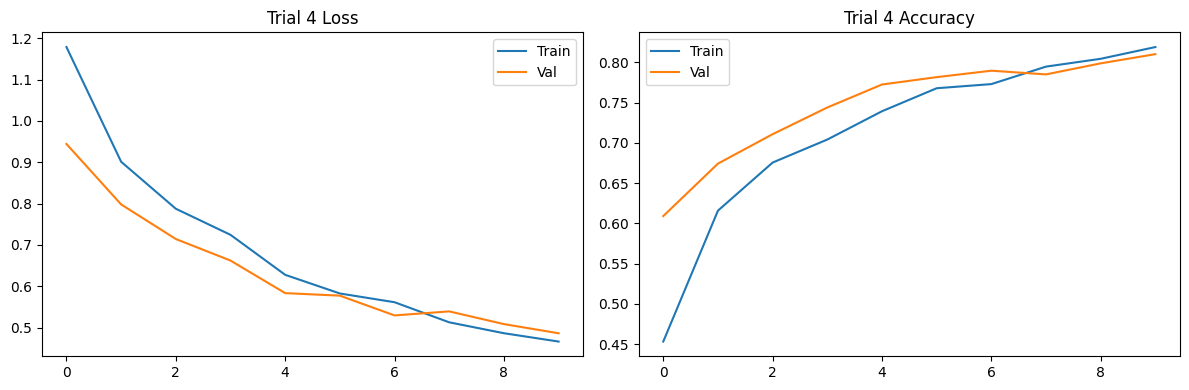

[I 2025-04-09 18:51:25,088] Trial 4 finished with value: 0.8096433921224944 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}. Best is trial 4 with value: 0.8096433921224944.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 181ms/step - accuracy: 0.2714 - loss: 5.5385 - val_accuracy: 0.3086 - val_loss: 1.3748
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3082 - loss: 1.3727 - val_accuracy: 0.3086 - val_loss: 1.3760
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3110 - loss: 1.3764 - val_accuracy: 0.3086 - val_loss: 1.3745
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3086 - loss: 1.3733 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3048 - loss: 1.3778 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2953 - loss: 1.3793 - val_accuracy: 0.3086 - val_loss: 1.3749
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:52:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:52:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


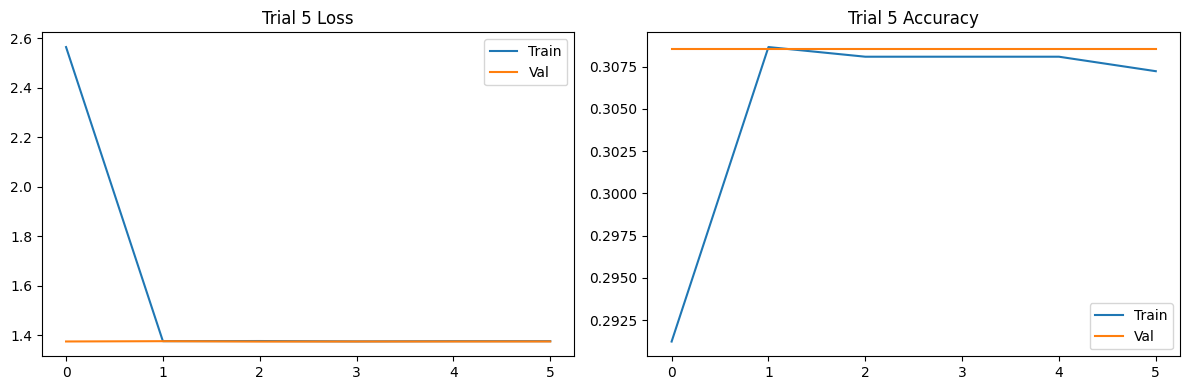

[I 2025-04-09 18:52:11,761] Trial 5 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10}. Best is trial 4 with value: 0.8096433921224944.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.2942 - loss: 8.3627 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3037 - loss: 1.3780 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3036 - loss: 1.3770 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3116 - loss: 1.3746 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3253 - loss: 1.3722 - val_accuracy: 0.3086 - val_loss: 1.3749
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:52:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:52:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


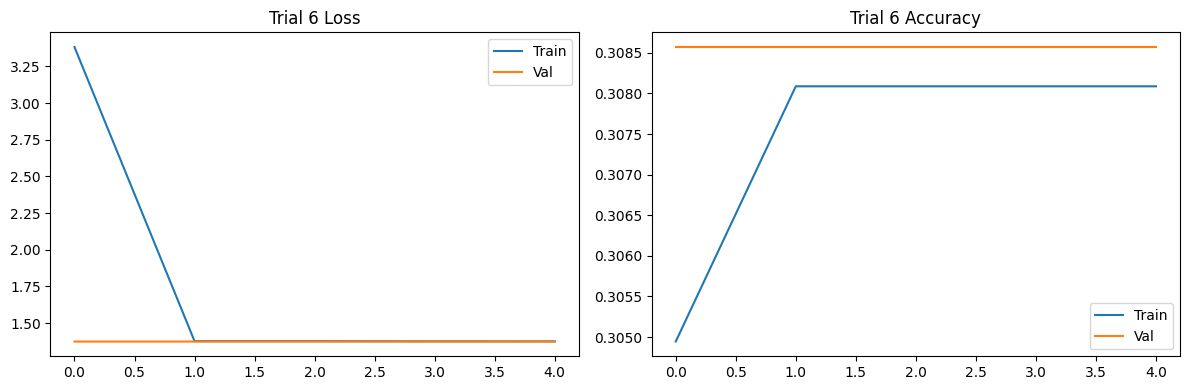

[I 2025-04-09 18:52:50,396] Trial 6 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 15}. Best is trial 4 with value: 0.8096433921224944.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.3873 - loss: 1.2980 - val_accuracy: 0.6251 - val_loss: 0.9301
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6184 - loss: 0.9007 - val_accuracy: 0.6731 - val_loss: 0.7836
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6680 - loss: 0.7594 - val_accuracy: 0.7326 - val_loss: 0.6554
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7379 - loss: 0.6404 - val_accuracy: 0.7646 - val_loss: 0.5888
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7720 - loss: 0.5554 - val_accuracy: 0.7760 - val_loss: 0.5728
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8269 - loss: 0.4683 - val_accuracy: 0.7451 - val_loss: 0.6403
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8427 - loss: 0.3815 - val_accuracy: 0.8011 - val_loss: 0.5315
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8790 - loss: 0.2926 - val_accuracy: 0.8240 - 

2025/04/09 18:53:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:53:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


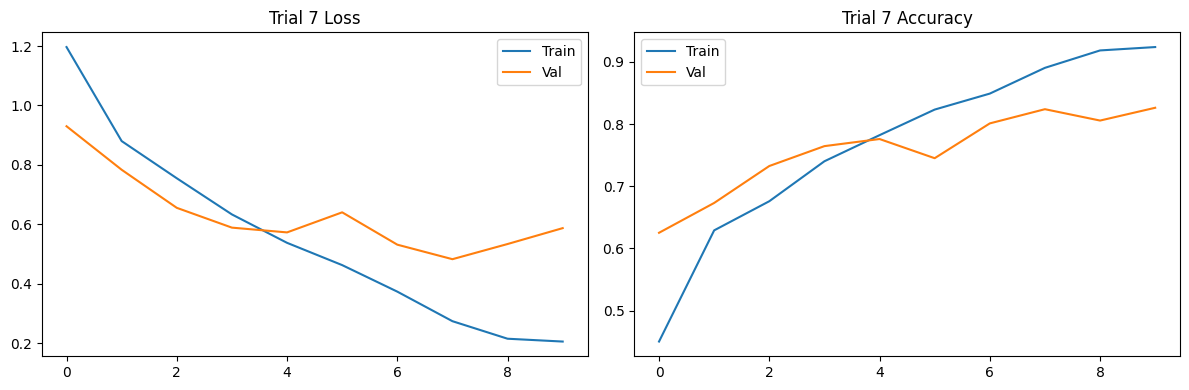

[I 2025-04-09 18:53:40,869] Trial 7 finished with value: 0.8192483213328253 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.3245 - loss: 1.5346 - val_accuracy: 0.5909 - val_loss: 0.9918
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6008 - loss: 0.9642 - val_accuracy: 0.6309 - val_loss: 0.8047
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6565 - loss: 0.8015 - val_accuracy: 0.7097 - val_loss: 0.6977
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7120 - loss: 0.7316 - val_accuracy: 0.6789 - val_loss: 0.7224
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7380 - loss: 0.6326 - val_accuracy: 0.7429 - val_loss: 0.6590
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7715 - loss: 0.5768 - val_accuracy: 0.7417 - val_loss: 0.6477
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8085 - loss: 0.4886 - val_accuracy: 0.7566 - val_loss: 0.5932
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8551 - loss: 0.3914 - val_accuracy: 0.7817 - 

2025/04/09 18:54:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:54:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


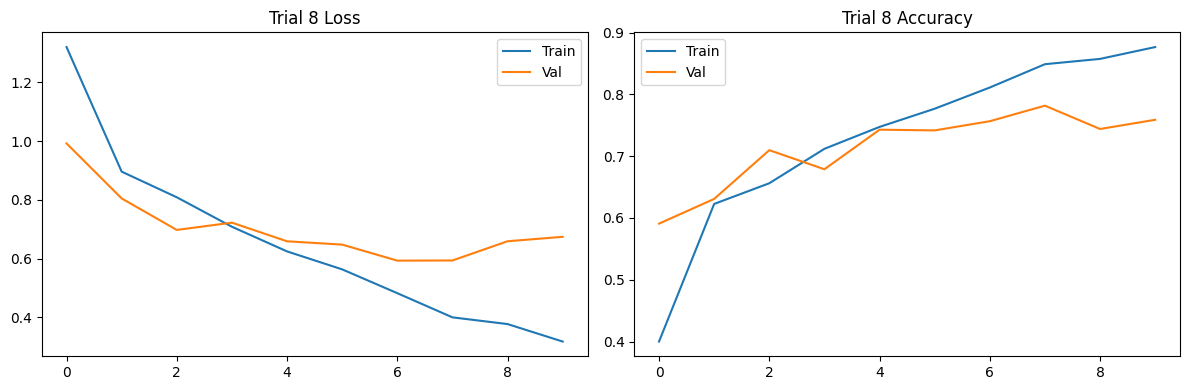

[I 2025-04-09 18:54:31,353] Trial 8 finished with value: 0.755927804012093 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.2763 - loss: 4.9693 - val_accuracy: 0.3086 - val_loss: 1.3761
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3118 - loss: 1.3768 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3056 - loss: 1.3776 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3098 - loss: 1.3740 - val_accuracy: 0.3086 - val_loss: 1.3746
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3192 - loss: 1.3734 - val_accuracy: 0.3086 - val_loss: 1.3753
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3143 - loss: 1.3732 - val_accuracy: 0.3086 - val_loss: 1.3747
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.3122 - loss: 1.3737 - val_accuracy: 0.3086 - val_loss: 1.3747
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/04/09 18:55:05 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:55:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


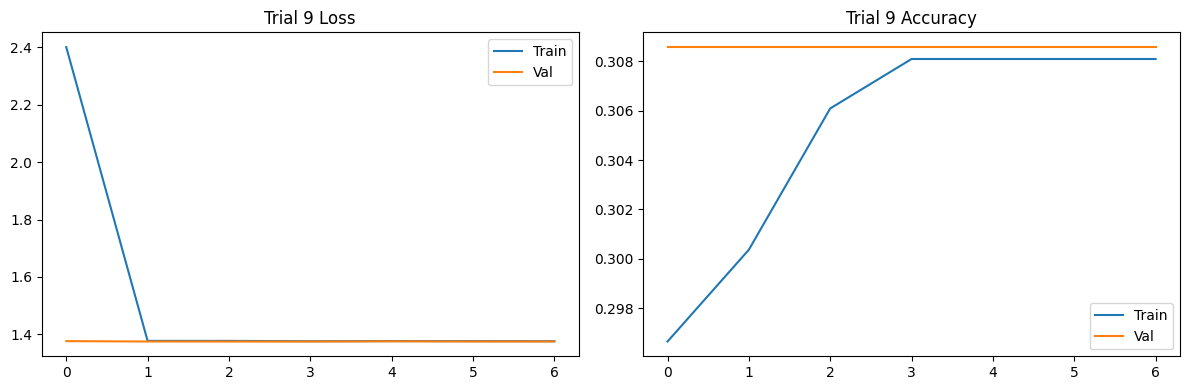

[I 2025-04-09 18:55:14,096] Trial 9 finished with value: 0.14552713661883968 and parameters: {'learning_rate': 0.01, 'batch_size': 64, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.3572 - loss: 1.3658 - val_accuracy: 0.6023 - val_loss: 0.9208
Epoch 2/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6061 - loss: 0.9300 - val_accuracy: 0.6857 - val_loss: 0.7524
Epoch 3/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6424 - loss: 0.8085 - val_accuracy: 0.7223 - val_loss: 0.7002
Epoch 4/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7220 - loss: 0.7043 - val_accuracy: 0.7360 - val_loss: 0.6393
Epoch 5/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7522 - loss: 0.6097 - val_accuracy: 0.7760 - val_loss: 0.5555
Epoch 6/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8026 - loss: 0.5123 - val_accuracy: 0.7840 - val_loss: 0.5443
Epoch 7/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8301 - loss: 0.4316 - val_accuracy: 0.8114 - val_loss: 0.5159
Epoch 8/15
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8452 - loss: 0.3858 - val_accuracy: 0.7943 - 

2025/04/09 18:56:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:56:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


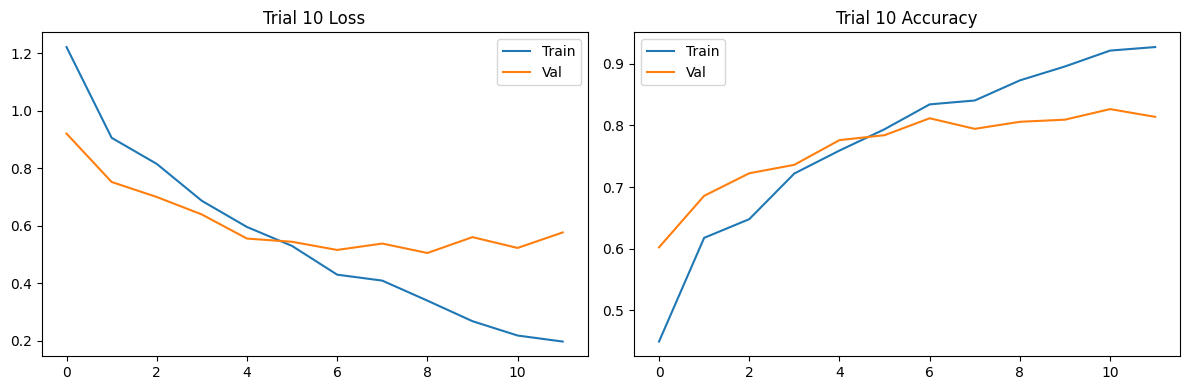

[I 2025-04-09 18:56:08,638] Trial 10 finished with value: 0.8092402322144658 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 15}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.3838 - loss: 1.3020 - val_accuracy: 0.5680 - val_loss: 1.0183
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5561 - loss: 0.9878 - val_accuracy: 0.6629 - val_loss: 0.8068
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6526 - loss: 0.8225 - val_accuracy: 0.6846 - val_loss: 0.7563
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6832 - loss: 0.7568 - val_accuracy: 0.6731 - val_loss: 0.7561
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6931 - loss: 0.7363 - val_accuracy: 0.7383 - val_loss: 0.6526
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7349 - loss: 0.6587 - val_accuracy: 0.7371 - val_loss: 0.6361
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7585 - loss: 0.5917 - val_accuracy: 0.7429 - val_loss: 0.6095
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7684 - loss: 0.5820 - val_acc

2025/04/09 18:56:54 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:57:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


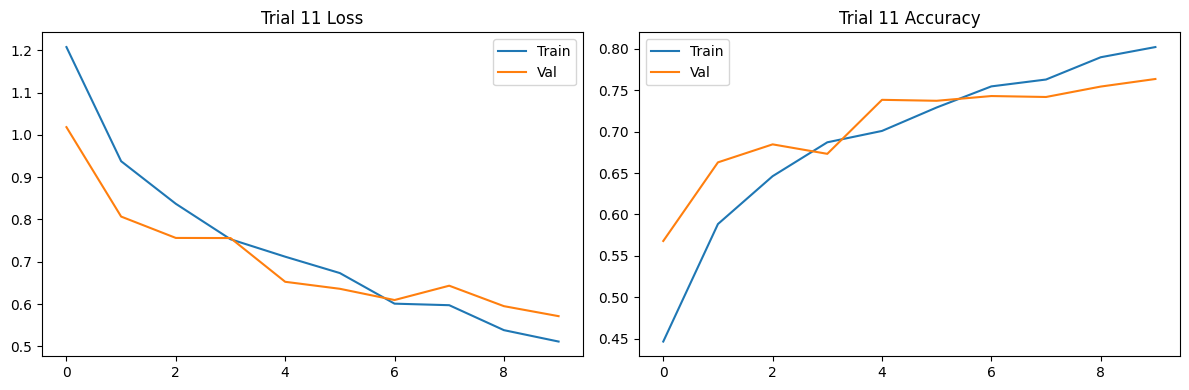

[I 2025-04-09 18:57:03,011] Trial 11 finished with value: 0.7485842830933929 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.3354 - loss: 1.3462 - val_accuracy: 0.4857 - val_loss: 1.1187
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5115 - loss: 1.0817 - val_accuracy: 0.6091 - val_loss: 0.9041
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5950 - loss: 0.9151 - val_accuracy: 0.6686 - val_loss: 0.7999
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6460 - loss: 0.8381 - val_accuracy: 0.6594 - val_loss: 0.7817
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6808 - loss: 0.7748 - val_accuracy: 0.6960 - val_loss: 0.7117
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6995 - loss: 0.7130 - val_accuracy: 0.6914 - val_loss: 0.7134
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7346 - loss: 0.6695 - val_accuracy: 0.7200 - val_loss: 0.6487
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7249 - loss: 0.6484 - val_accuracy: 0.7474 - 

2025/04/09 18:57:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:57:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


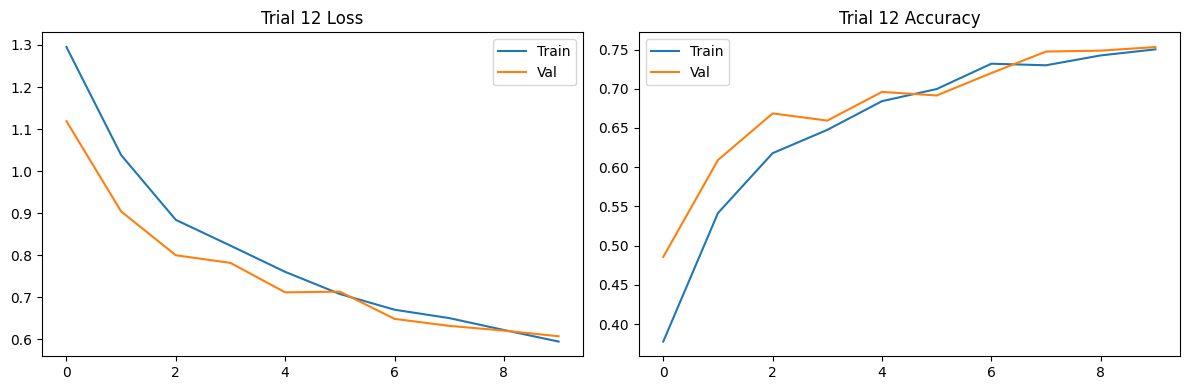

[I 2025-04-09 18:57:53,011] Trial 12 finished with value: 0.7341465679188506 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.3495 - loss: 1.3019 - val_accuracy: 0.5874 - val_loss: 0.9678
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6038 - loss: 0.9439 - val_accuracy: 0.6183 - val_loss: 0.8547
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6569 - loss: 0.8082 - val_accuracy: 0.6869 - val_loss: 0.7672
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7005 - loss: 0.7190 - val_accuracy: 0.6491 - val_loss: 0.7938
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7080 - loss: 0.6899 - val_accuracy: 0.7623 - val_loss: 0.6235
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7773 - loss: 0.5853 - val_accuracy: 0.7509 - val_loss: 0.5999
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7740 - loss: 0.5602 - val_accuracy: 0.7543 - val_loss: 0.6227
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7896 - loss: 0.5248 - val_acc

2025/04/09 18:58:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:58:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


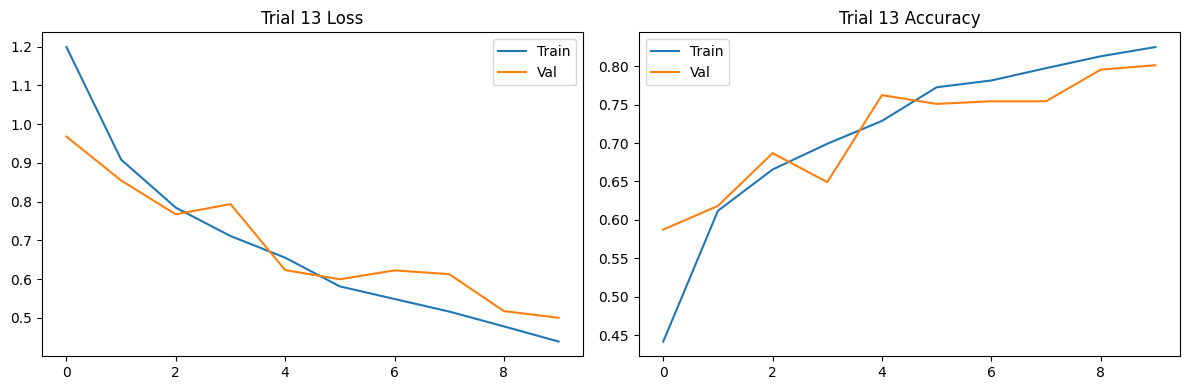

[I 2025-04-09 18:58:47,226] Trial 13 finished with value: 0.8035368939766261 and parameters: {'learning_rate': 0.0001, 'batch_size': 32, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - accuracy: 0.3584 - loss: 1.3072 - val_accuracy: 0.5440 - val_loss: 1.0271
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5502 - loss: 1.0223 - val_accuracy: 0.6263 - val_loss: 0.8766
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6269 - loss: 0.8801 - val_accuracy: 0.6480 - val_loss: 0.8198
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6702 - loss: 0.8107 - val_accuracy: 0.6229 - val_loss: 0.8589
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6791 - loss: 0.7807 - val_accuracy: 0.6869 - val_loss: 0.7252
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7095 - loss: 0.7193 - val_accuracy: 0.7200 - val_loss: 0.6941
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7457 - loss: 0.6358 - val_accuracy: 0.7246 - val_loss: 0.6635
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7457 - loss: 0.6127 - val_accuracy: 0.7463 - 

2025/04/09 18:59:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 18:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


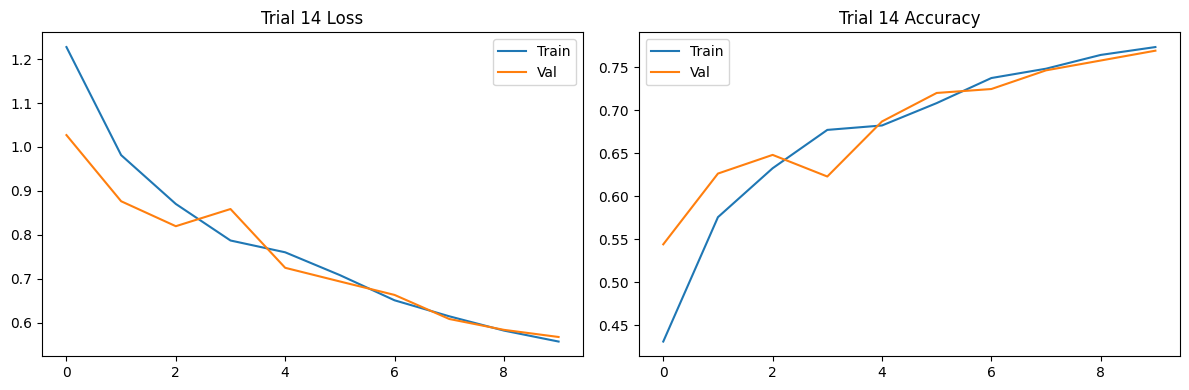

[I 2025-04-09 18:59:36,674] Trial 14 finished with value: 0.7687713406719008 and parameters: {'learning_rate': 0.0001, 'batch_size': 64, 'epochs': 10}. Best is trial 7 with value: 0.8192483213328253.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.4177 - loss: 1.3400 - val_accuracy: 0.5840 - val_loss: 0.9885
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6045 - loss: 0.9199 - val_accuracy: 0.6526 - val_loss: 0.8122
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6609 - loss: 0.8042 - val_accuracy: 0.6994 - val_loss: 0.7138
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7127 - loss: 0.6763 - val_accuracy: 0.6949 - val_loss: 0.6842
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7536 - loss: 0.5819 - val_accuracy: 0.7154 - val_loss: 0.6961
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8137 - loss: 0.4645 - val_accuracy: 0.8069 - val_loss: 0.5075
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8566 - loss: 0.3840 - val_accuracy: 0.8000 - val_loss: 0.5187
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8820 - loss: 0.3236 - val_acc

2025/04/09 19:00:22 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 19:00:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


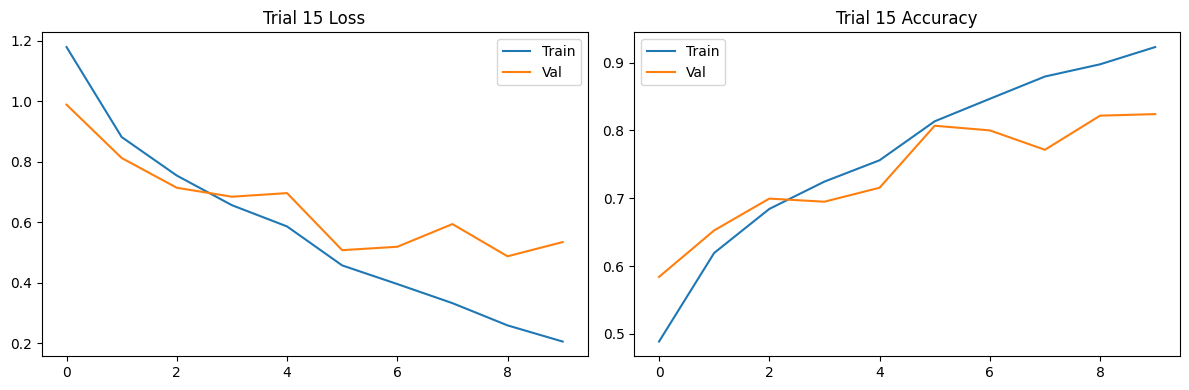

[I 2025-04-09 19:00:30,822] Trial 15 finished with value: 0.8208044580079574 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}. Best is trial 15 with value: 0.8208044580079574.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.4070 - loss: 1.2989 - val_accuracy: 0.6263 - val_loss: 0.8539
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6216 - loss: 0.8812 - val_accuracy: 0.6526 - val_loss: 0.8081
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6667 - loss: 0.7711 - val_accuracy: 0.7109 - val_loss: 0.6812
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7516 - loss: 0.6244 - val_accuracy: 0.7280 - val_loss: 0.6823
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7777 - loss: 0.5518 - val_accuracy: 0.7634 - val_loss: 0.5785
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8239 - loss: 0.4342 - val_accuracy: 0.7840 - val_loss: 0.5371
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8335 - loss: 0.4231 - val_accuracy: 0.8137 - val_loss: 0.5085
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8815 - loss: 0.3134 - val_accuracy: 0.7943 - 

2025/04/09 19:01:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 19:01:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


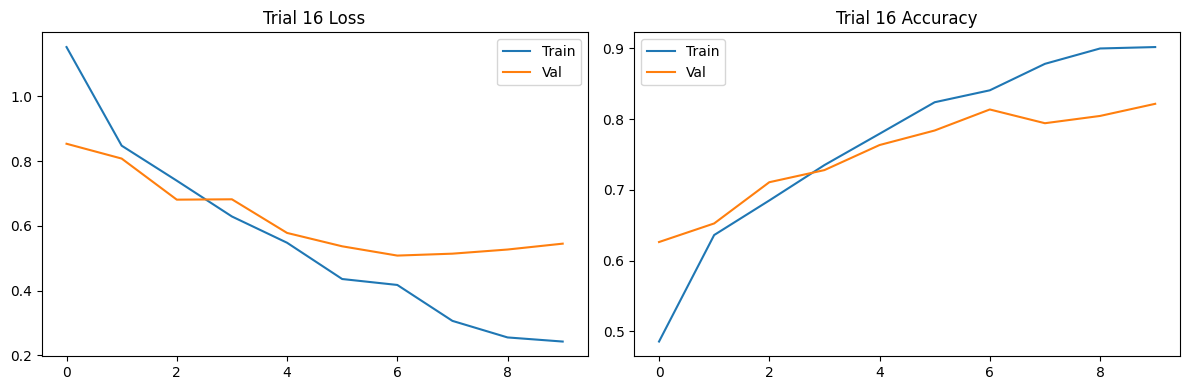

[I 2025-04-09 19:01:20,345] Trial 16 finished with value: 0.8036996532373047 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}. Best is trial 15 with value: 0.8208044580079574.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.4626 - loss: 1.1877 - val_accuracy: 0.6389 - val_loss: 0.8531
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6610 - loss: 0.8131 - val_accuracy: 0.6789 - val_loss: 0.7508
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7026 - loss: 0.6823 - val_accuracy: 0.6789 - val_loss: 0.7355
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7479 - loss: 0.6061 - val_accuracy: 0.7177 - val_loss: 0.6311
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7904 - loss: 0.4880 - val_accuracy: 0.7749 - val_loss: 0.5646
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8415 - loss: 0.3861 - val_accuracy: 0.7829 - val_loss: 0.5371
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8866 - loss: 0.3089 - val_accuracy: 0.8034 - val_loss: 0.5491
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8851 - loss: 0.2861 - val_acc

2025/04/09 19:02:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 19:02:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


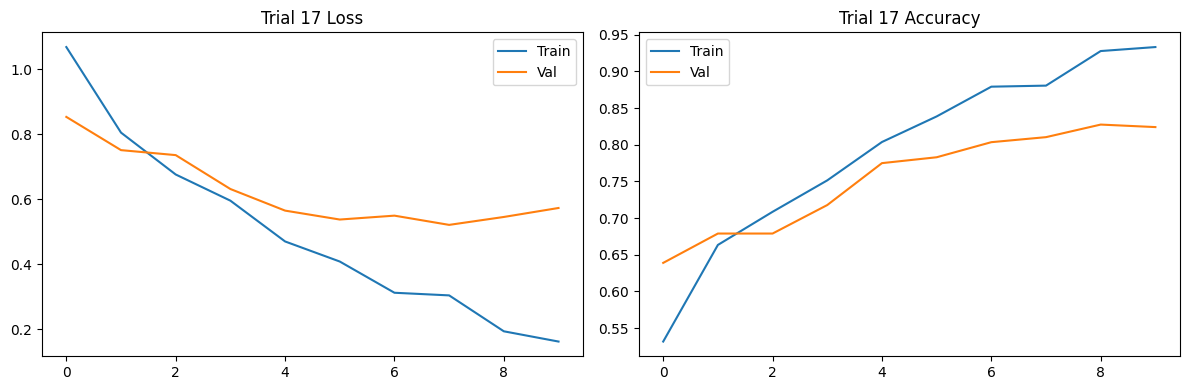

[I 2025-04-09 19:02:15,404] Trial 17 finished with value: 0.804670932524627 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 10}. Best is trial 15 with value: 0.8208044580079574.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.3957 - loss: 1.3161 - val_accuracy: 0.6080 - val_loss: 0.9025
Epoch 2/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6352 - loss: 0.8643 - val_accuracy: 0.6811 - val_loss: 0.7440
Epoch 3/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7017 - loss: 0.7282 - val_accuracy: 0.7166 - val_loss: 0.6405
Epoch 4/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7592 - loss: 0.5908 - val_accuracy: 0.7760 - val_loss: 0.5347
Epoch 5/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8136 - loss: 0.4680 - val_accuracy: 0.7097 - val_loss: 0.6888
Epoch 6/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8135 - loss: 0.4379 - val_accuracy: 0.7383 - val_loss: 0.6495
Epoch 7/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8573 - loss: 0.3364 - val_accuracy: 0.8149 - val_loss: 0.4885
Epoch 8/15
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8850 - loss: 0.3052 - val_acc

2025/04/09 19:03:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 19:03:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


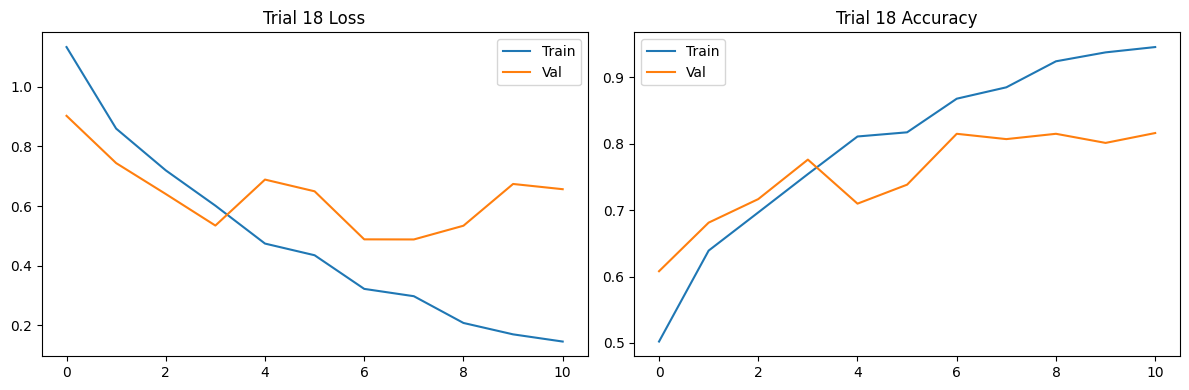

[I 2025-04-09 19:03:12,201] Trial 18 finished with value: 0.8045889269740497 and parameters: {'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15}. Best is trial 15 with value: 0.8208044580079574.
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.3376 - loss: 1.3749 - val_accuracy: 0.6114 - val_loss: 0.9578
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6054 - loss: 0.9311 - val_accuracy: 0.6754 - val_loss: 0.7744
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6882 - loss: 0.7613 - val_accuracy: 0.7177 - val_loss: 0.6752
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7543 - loss: 0.6270 - val_accuracy: 0.7246 - val_loss: 0.6572
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7673 - loss: 0.5918 - val_accuracy: 0.7486 - val_loss: 0.6436
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8043 - loss: 0.5022 - val_accuracy: 0.7691 - val_loss: 0.5919
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8222 - loss: 0.4494 - val_accuracy: 0.7691 - val_loss: 0.5730
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8382 - loss: 0.3894 - val_accuracy: 0.8217 - 

2025/04/09 19:03:53 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/09 19:04:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


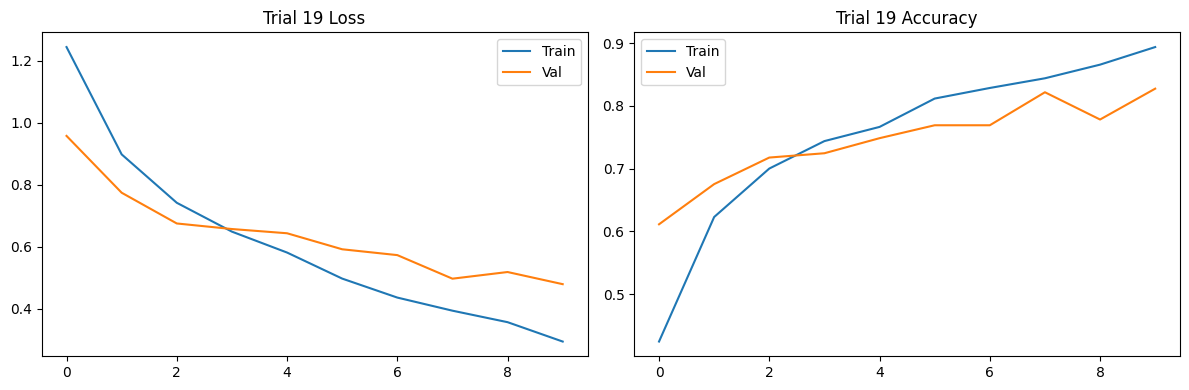

[I 2025-04-09 19:04:01,965] Trial 19 finished with value: 0.825130841854246 and parameters: {'learning_rate': 0.001, 'batch_size': 64, 'epochs': 10}. Best is trial 19 with value: 0.825130841854246.



Best trial:
Trial #19 with value 0.8251
Hyperparameters:
  learning_rate: 0.001
  batch_size: 64
  epochs: 10


In [10]:
# ========== OPTUNA STUDY ==========
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=TRIALS)

print("\nBest trial:")
print(f"Trial #{study.best_trial.number} with value {study.best_value:.4f}")
print("Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

# ========== SELECT BEST MODEL FROM MLRUNs AND EVALUATE BEST MODEL ON TEST SET ==========

In [ ]:
# ========== SELECT BEST MODEL AFTER TRAINING AND LOG INFORMATION ==========
def get_best_run(experiment_name):
    client = mlflow.tracking.MlflowClient()
    exp = client.get_experiment_by_name(experiment_name)
    runs = client.search_runs(exp.experiment_id, order_by=["metrics.val_f1 DESC"])
    return runs[0]


🔍 Loading images: 100%|██████████| 4374/4374 [00:09<00:00, 457.60it/s]


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Accuracy : 0.8274
Precision: 0.8246
Recall   : 0.8274
F1-score : 0.8251


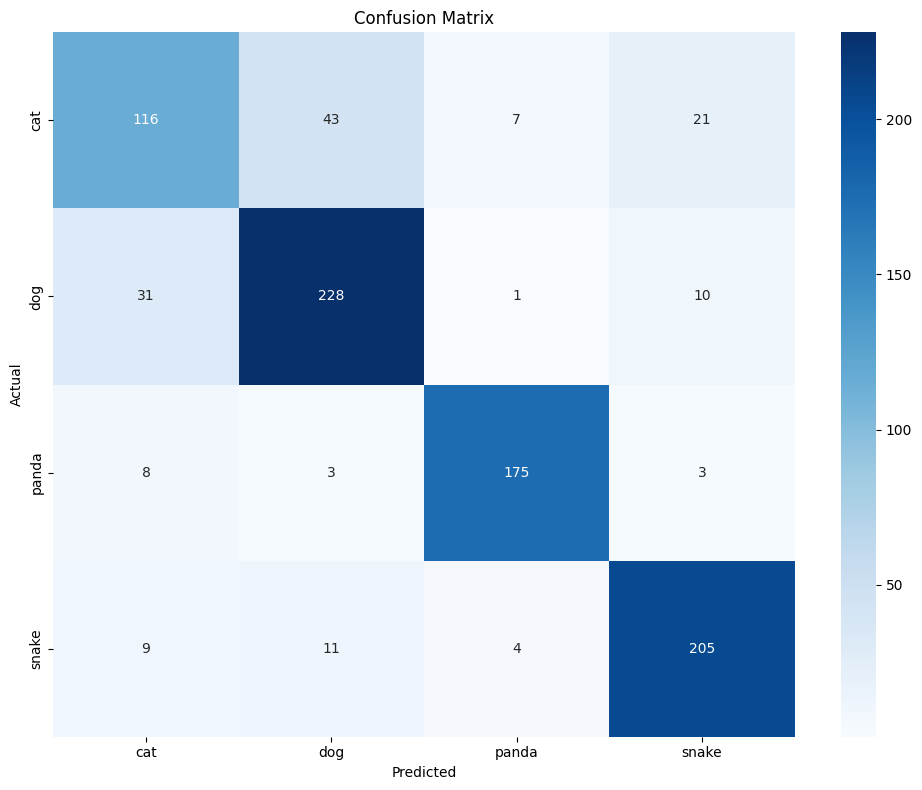

In [12]:
#from config import *
#from dataset_utils import load_data
#from mlflow_utils import get_best_run
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import os
import random

X_train, X_test, y_train, y_test, le = load_data(DATA_DIR, IMG_SIZE)

# Load best model from mlruns
import mlflow.keras

best_run = get_best_run(EXPERIMENT_NAME)

model_path = f"/kaggle/working/mlruns/{best_run.info.experiment_id}/{best_run.info.run_id}/artifacts/model"
model = mlflow.keras.load_model(model_path)

# Predict
y_pred = np.argmax(model.predict(X_test), axis=1)

# Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")

# Print metrics
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()




# CHECK INFORMATION AFTER TRAING AND TUNNING HYPERPARAMETERS WITH EXPEREMENT TRACKING(MLFLow) ON BEST MODEL

🎯 Best Run ID: 2e4e7348b7c7494a8416c31b08703e89

📌 Hyperparameters:
{'batch_size': '64',
 'dataset_hash': 'd2a5156735ec080cb63967194d5a4f4a',
 'dropout': '0.5',
 'epochs': '10',
 'learning_rate': '0.001'}

📈 Metrics:
{'val_accuracy': 0.8274285714285714,
 'val_f1': 0.825130841854246,
 'val_precision': 0.8246429080905108,
 'val_recall': 0.8274285714285714}

📂 Dataset hash: d2a5156735ec080cb63967194d5a4f4a

📊 Loss/Accuracy Plot: plot_trial_19.png


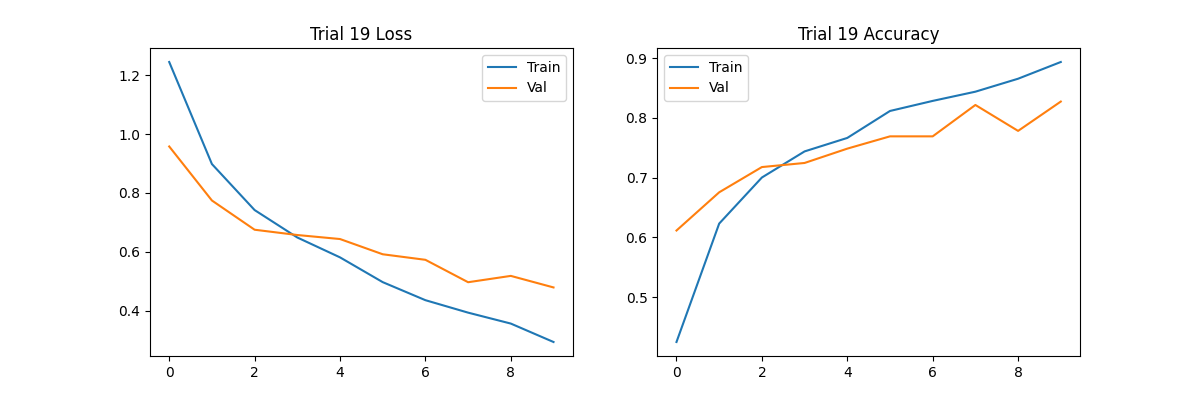

In [13]:
from pprint import pprint
from PIL import Image
from IPython.display import display
import os

# In thông tin của best run
print(f"🎯 Best Run ID: {best_run.info.run_id}")
print("\n📌 Hyperparameters:")
pprint(best_run.data.params)

print("\n📈 Metrics:")
pprint(best_run.data.metrics)

# In dataset_hash nếu có
dataset_hash = best_run.data.params.get("dataset_hash")
if dataset_hash:
    print(f"\n📂 Dataset hash: {dataset_hash}")

# Hiển thị biểu đồ loss/accuracy đã log
plot_dir = f"/kaggle/working/mlruns/{best_run.info.experiment_id}/{best_run.info.run_id}/artifacts/plots"

# Tìm file plot trong thư mục plots
if os.path.exists(plot_dir):
    plot_files = [f for f in os.listdir(plot_dir) if f.startswith("plot_trial")]
    if plot_files:
        plot_path = os.path.join(plot_dir, plot_files[0])
        print(f"\n📊 Loss/Accuracy Plot: {plot_files[0]}")
        display(Image.open(plot_path))
    else:
        print("⚠️ Không tìm thấy plot_trial_*.png")
else:
    print("⚠️ Không tìm thấy thư mục artifacts/plots")


# ========== DISPLAY 10 RANDOM TEST IMAGES WITH PREDICTIONS ==========

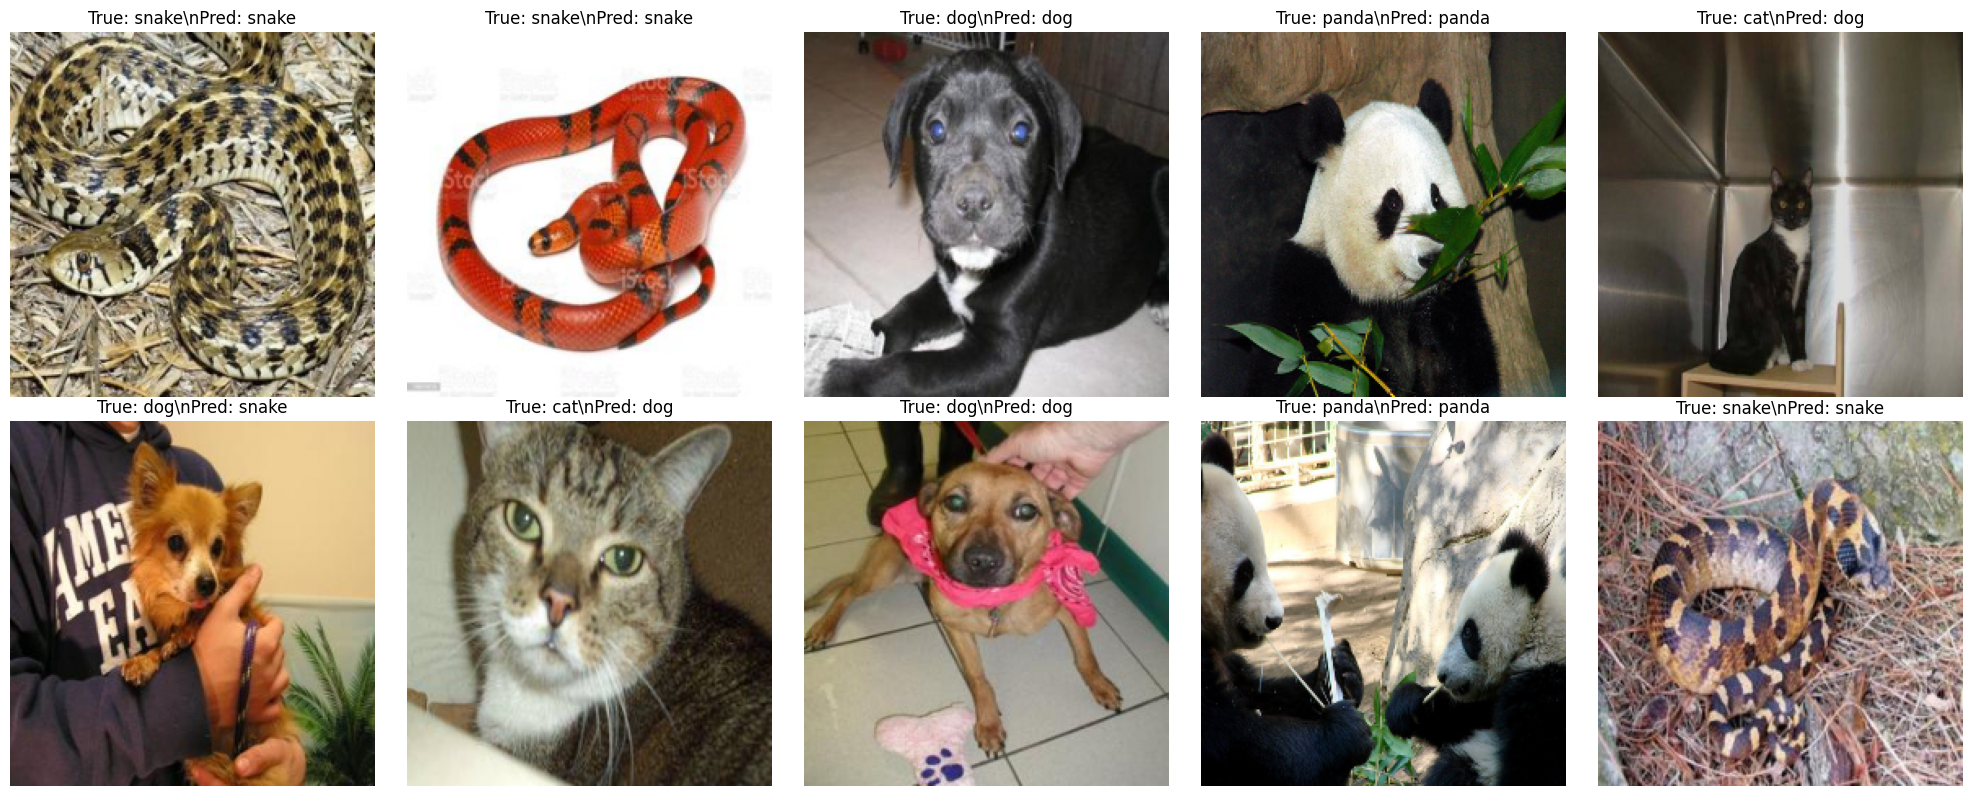

In [14]:

# Show 10 random test images
indices = random.sample(range(len(X_test)), 10)
plt.figure(figsize=(20, 8))
for i, idx in enumerate(indices):
    img = X_test[idx]
    true = le.inverse_transform([y_test[idx]])[0]
    pred = le.inverse_transform([y_pred[idx]])[0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true}\\nPred: {pred}")
    plt.axis('off')
plt.tight_layout()
plt.savefig("sample_predictions.png")
plt.show()